## Project: Predicting house sale prices
## Part 2: Test sample scoring and final model selection
**Data:** housing data for the city of Ames, Iowa, USA, 2006 to 2010  
**Data description:** https://s3.amazonaws.com/dq-content/307/data_description.txt  
**Source:** https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627  
**Source pdf:** https://www.tandfonline.com/doi/pdf/10.1080/10691898.2011.11889627?needAccess=true


In [1]:
# Set-up auto-reload functions for faster debugging 
# (automatically refreshes changes in subpackages codes)
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
# Import parent directory (main project directory)
# for packages importing
import sys
import os

# Getting the parent directory name in which your script is running
parent = os.path.dirname(os.path.realpath(''))

# adding the parent directory to
# the sys.path.
sys.path.append(parent)

# now we can import the module in the parent
# directory.

In [3]:
# Project packages import
import gp23package.data.make_dataset as gp23md
import gp23package.explore_visualise.eda as gp23eda
import gp23package.features.build_features as gp23feat
import gp23package.models.hyperparameters_model as gp23hyperparam
import gp23package.models.train_model as gp23train
# Pylance highligting package issue (not to be worried about)
# https://github.com/microsoft/pylance-release/blob/main/TROUBLESHOOTING.md#unresolved-import-warnings

# Standard Python libraries import
from IPython.display import display, HTML #  tidied-up display
from time import time #  project timer
from itertools import chain # for list iterations

# plots
import matplotlib.pyplot as plt
import seaborn as sn

# Statistics
from scipy import stats
from scipy.stats import mstats

# Sklearn
from sklearn.feature_selection import (SelectKBest, chi2, f_regression, RFE, mutual_info_regression,
                                      SequentialFeatureSelector, SelectFromModel)
from sklearn.preprocessing import (normalize, MinMaxScaler)
from sklearn.metrics import (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score)
from sklearn.model_selection import (train_test_split, cross_val_score, KFold, GridSearchCV)
from sklearn.linear_model import (LinearRegression, Ridge, ElasticNet, Lasso, TheilSenRegressor, RANSACRegressor,
                                  HuberRegressor , SGDRegressor, Lars, ElasticNet, RidgeCV)

#statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import statsmodels as sm
import statsmodels.stats.stattools as smt
import statsmodels.stats.diagnostic as smd

# Other
from dython import nominal # Correlations between categorical variables

# Necessary packages
import gp23package
import numpy as np
import pandas as pd
import pickle # dump models

#turning on plot display in JN
%matplotlib inline 
# Setting pandas display options
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 250

### 8. Importing models & data transformations

In [4]:
# Starting project timer
tic_all = time()

In [5]:
#Loading saved models and transformation objects
filename = 'model_list.sav'
file = os.path.join(parent, 'models', filename)
with open(file, 'rb') as file_open:
    model_list = pickle.load(file_open)

filename = 'boxCox_dict.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    boxCox_dict = pickle.load(file_open)

filename = 'data_optbin.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    data_optbin = pickle.load(file_open)

filename = 'var_dict.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    var_dict = pickle.load(file_open)

# Load train / valid results of models
filename = 'chosen_bestModels.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    chosen_bestModels = pickle.load(file_open)

# Loading test datasets
filename = 'X_test.csv'
file = os.path.join(parent, 'data\interim', filename)
X_test = pd.read_csv(file)

filename = 'y_test.csv'
file = os.path.join(parent, 'data\interim', filename)
y_test = pd.read_csv(file, index_col=0, squeeze=True)

# Loading variable lists

filename = 'discrete.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    discrete = pickle.load(file_open)

filename = 'categorical.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    categorical = pickle.load(file_open)

filename = 'continuous.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    continuous = pickle.load(file_open)

# Load train/valid scaler too keep same transformations on production scoring
filename = 'train_scaler.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    train_scaler = pickle.load(file_open)


C:\Users\tgusc\AppData\Local\Temp\ipykernel_24524\1345785022.py:35: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  y_test = pd.read_csv(file, index_col=0, squeeze=True)


### 9. Scoring new data - test dataset
#### 9.1 Applying transformations to new data

In [6]:
# MANUAL_INPUT
# Scoring new vector of data
# For this we need to have list of used variables for final models
# If we have more than one model we would have to prepare more list concatenating all lists
# Attention: for scoring we do need to use original variable list with exactly the same order of variables
# In our current case var_dict["BKWD_20"]

scoring_vars = list(set(var_dict["BKWD_20"] + var_dict["FWD_10"]))
scoring_dict = var_dict

scoring_varsRaw = []
# List of prefixes differentiating engineered variables from original variables
prefixes = ["WOE_", "Box_"]

# taking all variable variations for final models
for var in chosen_bestModels["variable_set"].unique():
    # for each variable in variable set
    for i in var_dict[var]:
        # Removing prefixes from prefixes list
        for prefix in prefixes:
            i = i.removeprefix(prefix)
    # Adding raw variable name to scoring vars (if there are more than 1 variable lists there can be duplicates)
        scoring_varsRaw.append(i)

# Deduplicating variable names
# Final list will probably come in different order than used source lists
scoring_varsRaw = list(set(scoring_varsRaw))
print('*** raw scoring_vars ***')
print(scoring_varsRaw,'\n')

# Remark: in this project we divided data to train_valid / test samples after preliminary cleaning. In real-world cases
# we will not have access to incoming data, hence all the preliminary data cleaning would have to be done on new data
# as well. 

# Limiting number of input variables
X_test = X_test[scoring_varsRaw]

# Transforming y metric
# we are not winsorizing test data outcome variable as this would lead to false fit metrics
y2_test = np.log(y_test) 

# Creating empty subset of final scoring variavbles (engineered)
scoringFinal_vars = list(set(scoring_varsRaw).intersection(discrete))
print('*** discrete variables intersection ***')
print(scoringFinal_vars,'\n')
print('*** Variables used for scoring ***')
print(scoring_vars,'\n')

*** raw scoring_vars ***
['Bsmt Qual', 'Overall Qual', 'Neighborhood', 'Overall Cond', 'TotRms AbvGrd', 'MS Zoning', '2nd Flr SF', 'Condition 1', 'Garage Area', 'Sale Condition', 'Floor_area_ratio', 'Full Bath', 'Bsmt Exposure', 'House Style', 'MS SubClass', 'BsmtFin Type 1', 'Kitchen Qual', 'Bsmt Half Bath', 'Bathroom_total', 'Heating QC', 'Functional', 'Fireplaces', 'Central Air', 'Bsmt Full Bath'] 

*** discrete variables intersection ***
['Bsmt Half Bath', 'Bathroom_total', 'Overall Cond', 'TotRms AbvGrd', 'Heating QC', 'Full Bath', 'Fireplaces', 'Bsmt Qual', 'Central Air', 'Kitchen Qual', 'Overall Qual', 'Bsmt Full Bath'] 

*** Variables used for scoring ***
['Bsmt Qual', 'Box_Garage Area', 'Overall Qual', 'WOE_MS Zoning', 'Overall Cond', 'TotRms AbvGrd', 'WOE_MS SubClass', 'Box_Floor_area_ratio', 'WOE_Bsmt Exposure', 'Full Bath', 'WOE_Functional', 'Kitchen Qual', 'WOE_BsmtFin Type 1', 'WOE_Sale Condition', 'Bathroom_total', 'Heating QC', 'WOE_Condition 1', 'Fireplaces', 'Central 

In [7]:
# Transforming input variables
# WoE transformation for categorical variables (common values between categorical vars and scoring_vars)
for i in set(categorical).intersection(scoring_varsRaw) :
    X_test["WOE_"+i] = data_optbin.transform(data = X_test, var_name = i)   
# Box-Cox power transformation for continuous variables (common values between continuous and scoring_vars)
# We use lambdas from boxCox_dict dictionary (lambda values calculated on train_valid dataset). This is to prevent
# Target information leakage between samples
for i in set(continuous).intersection(scoring_varsRaw) :
    X_test["Box_"+i] = stats.boxcox(x = X_test[i]+1 , lmbda = boxCox_dict[i])

Neighborhood : Landmrk  - value is not present in the  binning table
MS SubClass : C150  - value is not present in the  binning table


In [8]:
# Checking
# data_optbin["Neighborhood"]
X_test[X_test["Neighborhood"]=="Landmrk"][["WOE_Neighborhood","Neighborhood"]]

,WOE_Neighborhood,Neighborhood
288,0.080165,Landmrk


We see here that for 'Neighborhood' variable in test dataset we encountered 'Landmrk' value which has only 1 observation. According to our adopted WOE transformation function we will assign WoE value of "Other" group (least frequent group in binning dictionary)

In [9]:
# Normalizing data using scaler used on train_valid sample (preventing data leakage between samples)
X_test[scoring_vars] = train_scaler.fit_transform(X_test[scoring_vars])

#### 9.2 Test data model performance

In [20]:
# Checking which models performs best on test dataset
test_results = pd.DataFrame()

# iterating through best models
for i in model_list:
    predictions = model_list[i]['model'].predict(X_test[scoring_dict[model_list[i]['variables']]])
    mae = mean_absolute_error(y2_test, predictions)
    mse = mean_squared_error(y2_test, predictions)
    rmse = np.sqrt(mean_squared_error(y2_test, predictions))
    r2 = r2_score(y2_test, predictions)
    temp_df = pd.DataFrame(data = {'rmse': rmse, 'r_squared': r2, 'mae' : mae, 'mse' : mse} , index=[i])
    test_results = pd.concat([test_results, temp_df])

test_results.sort_values(by="r_squared", ascending = False, inplace = True)
test_results

,rmse,r_squared,mae,mse
model6_theil,0.154256,0.853284,0.118636,0.023795
model5_huber,0.166726,0.828605,0.129939,0.027797
model4_ridge,0.167265,0.827495,0.130514,0.027978
model3_elasticNet,0.167485,0.827041,0.130680,0.028051
model2_lasso,0.167544,0.826919,0.130729,0.028071
model1_lr,0.167555,0.826895,0.130739,0.028075


Theil model (which was previously worst performing on train/valid cross validation) is the best fitted model to test data.

#### 9.4 Performance stability

In [19]:
# TO DO NEXT - check why r_squared is calculated incorrectly


X_test

,Bsmt Qual,Overall Qual,Neighborhood,Overall Cond,TotRms AbvGrd,MS Zoning,2nd Flr SF,Condition 1,Garage Area,Sale Condition,Floor_area_ratio,Full Bath,Bsmt Exposure,House Style,MS SubClass,BsmtFin Type 1,Kitchen Qual,Bsmt Half Bath,Bathroom_total,Heating QC,Functional,Fireplaces,Central Air,Bsmt Full Bath,WOE_Condition 1,WOE_Neighborhood,WOE_MS Zoning,WOE_Sale Condition,WOE_Bsmt Exposure,WOE_House Style,WOE_Functional,WOE_MS SubClass,WOE_BsmtFin Type 1,Box_Garage Area,Box_Floor_area_ratio,Box_2nd Flr SF
0,0.8,0.625,CollgCr,0.500,0.555556,RL,0.0,Norm,660.0,Abnorml,0.438847,0.5,No,1Story,C20,GLQ,0.666667,0.0,0.6,1.00,Typ,0.333333,1.0,0.333333,0.700373,0.553745,1.000000,0.0,0.56173,0.047827,1.0,1.000000,1.000000,0.605403,0.737105,0.000000
1,0.8,0.375,CollgCr,0.625,0.222222,RL,0.0,Norm,462.0,Normal,0.204533,0.0,No,1Story,C20,Unf,0.333333,0.0,0.2,1.00,Typ,0.000000,1.0,0.000000,0.700373,0.553745,1.000000,1.0,0.56173,0.047827,1.0,1.000000,1.000000,0.454114,0.465149,0.000000
2,0.8,0.250,MeadowV,0.625,0.111111,RM,462.0,Norm,297.0,Normal,1.094612,0.0,Gd,SLvl,C180,GLQ,0.333333,0.0,0.2,0.50,Typ,0.333333,1.0,0.333333,0.700373,0.000000,0.349345,1.0,1.00000,-0.235484,1.0,0.517406,1.000000,0.317859,0.961988,4.118091
3,1.0,0.750,Crawfor,0.500,0.222222,RM,0.0,Norm,482.0,Partial,0.668337,0.5,Gd,1Story,C120,GLQ,0.666667,1.0,0.6,1.00,Typ,0.333333,1.0,0.333333,0.700373,0.553745,0.349345,1.0,1.00000,0.047827,1.0,1.000000,1.000000,0.469905,0.862410,0.000000
4,1.0,0.875,NridgHt,0.500,0.888889,RL,1237.0,Norm,858.0,Partial,0.336032,0.5,Av,2Story,C60,GLQ,1.000000,0.0,0.6,1.00,Typ,0.333333,1.0,0.333333,0.700373,1.000000,1.000000,1.0,1.00000,0.047827,1.0,1.000000,1.000000,0.747861,0.644288,4.507176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,0.8,0.500,ClearCr,0.750,0.444444,RL,700.0,Norm,389.0,Normal,0.025013,0.5,Gd,1.5Fin,C50,Rec,0.666667,1.0,0.4,0.75,Typ,0.666667,1.0,0.000000,0.700373,0.689175,1.000000,1.0,1.00000,-0.235484,1.0,0.353826,0.471859,0.395268,0.011817,4.288733
582,0.6,0.500,BrDale,0.875,0.222222,RM,504.0,Norm,264.0,Normal,1.032143,0.0,No,2Story,C160,ALQ,0.666667,0.0,0.2,0.75,Typ,0.000000,1.0,0.000000,0.700373,0.000000,0.349345,1.0,0.56173,0.047827,1.0,0.419007,0.651145,0.288987,0.952949,4.154638
583,0.8,0.500,MeadowV,0.375,0.777778,RM,1230.0,Norm,576.0,Normal,1.018920,0.5,No,2Story,C160,ALQ,0.333333,0.0,0.6,0.75,Maj1,0.333333,1.0,0.333333,0.700373,0.000000,0.349345,1.0,0.56173,0.047827,0.0,0.419007,0.651145,0.542499,0.950867,4.505083
584,0.8,0.500,Gilbert,0.500,0.444444,RL,785.0,Norm,389.0,Normal,0.289539,0.5,No,2Story,C60,Unf,0.333333,0.0,0.4,0.75,Typ,0.333333,1.0,0.000000,0.700373,0.503229,1.000000,1.0,0.56173,0.047827,1.0,1.000000,1.000000,0.395268,0.590402,4.334099


In [17]:
y2_test

826     12.301383
2769    11.884489
1597    11.460579
1559    12.880292
1053    13.008659
          ...    
2115    12.531773
406     11.678440
2910    11.927681
360     12.089539
613     11.711776
Name: SalePrice, Length: 586, dtype: float64

In [16]:

test_sampling = X_test[scoring_vars].merge(y2_test, left_index = True, right_index = True)
for model in model_list:
    test_pred = model_list[model]['model'].predict(test_sampling[scoring_dict[model_list[model]['variables']]])
    r2 = r2_score(test_sampling["SalePrice"], test_pred)
    print(r2)

-1.384475018197723
-1.3843583595134294
-1.3837093162491927
-1.3822240371163286
-1.3839133330767703
-1.1681911508931742


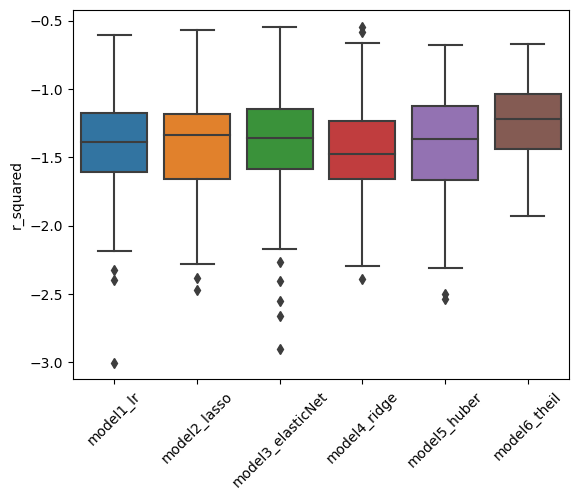

Test sample size -  52
R-squared standard deviation by model on test samples
model1_lr            0.359440
model2_lasso         0.391904
model3_elasticNet    0.406459
model4_ridge         0.359269
model5_huber         0.399792
model6_theil         0.283455
Name: r_squared, dtype: float64
RMSE standard deviation by model on test samples
model1_lr            0.046311
model2_lasso         0.053936
model3_elasticNet    0.052941
model4_ridge         0.047412
model5_huber         0.051131
model6_theil         0.042441
Name: rmse, dtype: float64


In [11]:
# Checking heteroscedasticity influence on sampling from test dataset
test_sampling = X_test[scoring_vars].merge(y2_test, left_index = True, right_index = True)
sampleTests_results = pd.DataFrame()

# Sampling 1000x 40% observations from test dataset and checking model performance
for model in model_list:
    for i in range(100):
        test = test_sampling.sample(frac=0.40)
        test_pred = model_list[model]['model'].predict(test[scoring_dict[model_list[model]['variables']]])
        mae = mean_absolute_error(pd.Series(test["SalePrice"]), test_pred)
        mse = mean_squared_error(test["SalePrice"], test_pred)
        rmse = np.sqrt(mean_squared_error(test["SalePrice"], test_pred))
        mape = mean_absolute_percentage_error(test["SalePrice"], test_pred)
        r2 = r2_score(test["SalePrice"], test_pred)
        temp_df = pd.DataFrame(data = {'rmse': rmse, 'r_squared': r2, 'mae' : mae, 'mse' : mse,
                                       'iteration' : i} , index=[model])
        sampleTests_results = pd.concat([sampleTests_results, temp_df])
        
sn.boxplot(x = sampleTests_results.index, y = 'r_squared', data = sampleTests_results)
plt.xticks(rotation = 45)
plt.show()
print('Test sample size - ',int(0.4*len(test_sampling)))
print('R-squared standard deviation by model on test samples')
print(sampleTests_results.groupby(sampleTests_results.index)["r_squared"].std())
print('RMSE standard deviation by model on test samples')
print(sampleTests_results.groupby(sampleTests_results.index)["rmse"].std())

Altough not suggested by train/valid performance Thiel-Sen regression seems to be best performing on test dataset. All regressions seems to be pretty stable on randomly generated subsamples. 

#### 9.5 Model diagnostics

In [13]:
linearModel_diagnostics(model_in = 'model3_elasticNet', data_in = X_test, target = y2_test)

NameError: name 'linearModel_diagnostics' is not defined

In [ ]:
linearModel_diagnostics(model_in = 'model6_theil', data_in = X_test, target = y2_test)

In [ ]:
# Finishing project timer
toc_all = time()
# Total project computation time
print(f"Done in {(tic_all - toc_all)/60.0:.3f}min")

Conclusions:

